In [1]:
from utils.plotting import RewardHistory
from utils.epsilon import Epsilon
from utils.replay_memory import Transition, PrioritisedReplayMemory

import numpy as np
import random
import gym as gym
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from IPython import display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T

In [2]:
class DQNLinear(nn.Module):
    def __init__(self, *args):
        super(DQNLinear, self).__init__(*args)
        self.fc1 = nn.Linear(4, 128)
#         self.fc2 = nn.Linear(12, 12)
        self.fc3 = nn.Linear(128, 2)
        self.fcv = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        v = self.fcv(x)
        a = self.fc3(x)
        N = a.size()[1]
        q = v + 1/N * a
        
        return q

dqn = DQNLinear()
print(dqn)

# x = np.stack([screen, prev_screen], axis=2)
# x = np.expand_dims(x, axis=0)
# x = np.rollaxis(x, 3, 1)
x = torch.Tensor([1, 1, 1, 1])
x = torch.unsqueeze(x, 0)
x = Variable(x).float()
print(x.data.numpy().shape)
# print(x)
# x = Variable(torch.randn(2, 2, 180, 600))
        
output = dqn(x)
print(output.data.numpy().shape)

# create your optimizer
optimizer = optim.Adam(dqn.parameters(), lr=0.01)
criterion = nn.MSELoss()

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = dqn(x)
loss = criterion(output, Variable(torch.Tensor([0,0])))
loss.backward()
optimizer.step()    # Does the update

DQNLinear (
  (fc1): Linear (4 -> 128)
  (fc3): Linear (128 -> 2)
  (fcv): Linear (128 -> 1)
)
(1, 4)
(1, 2)


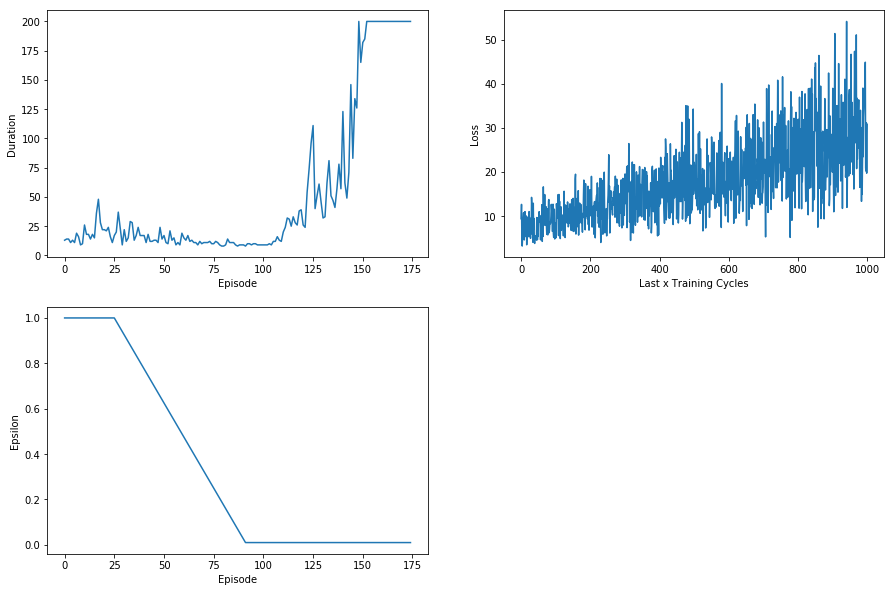

CPU times: user 2min 58s, sys: 3min 37s, total: 6min 35s
Wall time: 1min 50s


In [3]:
import copy
class DQNLinearLearner(object):
    def __init__(self, double_Q=False):
        self.env = gym.make("CartPole-v0")
        self.epsilon = Epsilon(start=1.0, end=0.01, update_increment=0.015)
        self.gamma = 0.99
        self.train_q_per_step = 4
        self.train_q_batch_size = 256
        self.steps_before_training = 500
        self.target_q_update_frequency = 100
        
        self.memory = PrioritisedReplayMemory(capacity=10000, e=0.1, alpha=0.5)
        self.Q = DQNLinear()
        self.Qt = copy.deepcopy(self.Q)# DQNLinear()
#         self.Qt.load_state_dict(self.Q.state_dict())
        self.use_double_Q = double_Q
        self.optimizer = optim.Adam(self.Q.parameters(), lr=1e-3)
        self.criterion = nn.MSELoss()

        self.reset()
        self.episode_rewards = []
        self.epsilon_log = []
        self.l_tq_squared_error = deque(maxlen=1000)
        

    def get_action(self, s):
        s = self.state_to_tensor(s)
        actions = self.Q(s)
        if np.random.rand() > self.epsilon.value():
            action = np.argmax(actions.data.numpy())
#             print(actions.data.numpy(), action)
#             print("not exploring", self.epsilon.value())
        else:
            action = self.env.action_space.sample()
#             print("exploring", action, "epsilon:", self.epsilon.value())
        return action

    def state_to_tensor(self, s):
        x = torch.Tensor(s)
        x = torch.unsqueeze(x, 0)
        x = Variable(x, volatile=True).float()
        return x
    
    def reset(self):
        self.s = self.env.reset()
    
    def train(self, nb_episodes=1, display=None):
#         self.env = gym.make("CartPole-v0")
        self.epsilon.isTraining = True
        step = 0
        
        for episode in range(nb_episodes):
            self.reset()
            episode_reward = 0
            
            while True:
                action = self.get_action(self.s)
                s_1, r, done, _ = self.env.step(action)
                    
                transition = Transition(self.s, action, s_1, r, done)
                self.memory.push(transition)
                episode_reward += r
                step += 1
                self.s = s_1
                
                if done:
                    break
                
                if step % self.train_q_per_step == 0 and step > self.steps_before_training:
                    self.train_q()
                    
                if step % self.target_q_update_frequency == 0 and step > self.steps_before_training:
                    self.update_target_q()

                if display is not None and step % 100 == 0:
                    display(self)
                    
            if step > self.steps_before_training:
                self.epsilon.increment() # increment epsilon per episode
#             print("Episode reward: ", episode_reward)
            self.episode_rewards.append(episode_reward)
            self.epsilon_log.append(self.epsilon.value())

        if display is not None:
            display(self)
    
    def train_q(self):
#         print("training q. Memory size:", len(self.memory))
        if self.train_q_batch_size >= len(self.memory):
            return
        
        transition, indices = self.memory.sample(self.train_q_batch_size)
        s, a, s_1, r, done = transition
        s = Variable(torch.from_numpy(s)).float()
        a = Variable(torch.from_numpy(a)).long()
        s_1 = Variable(torch.from_numpy(s_1), volatile=True).float()
        r = Variable(torch.from_numpy(r)).float()
        done = Variable(torch.from_numpy(1 - done)).float()
        

        Q = self.Q(s)
        Q = Q.gather(1, a)
        Qt = self.Qt(s_1)

        if self.use_double_Q:
            best_action = self.Q(s_1).max(dim=1)[1].view(-1, 1)
            y = r + done * self.gamma * Qt.gather(1, best_action)
        else:
            y = r + done * self.gamma * Qt.max(dim=1)[0].unsqueeze(1)

        y.volatile = False #weird

        loss = self.criterion(Q, y)
        error = Q - y
        self.memory.update(indices, error.squeeze().data.numpy())
#         loss = F.smooth_l1_loss(Q, y)
        self.l_tq_squared_error.append(loss.data.numpy().sum())
        self.optimizer.zero_grad()   # zero the gradient buffers
        loss.backward()
#         for param in self.Q.parameters():
#             param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def update_target_q(self):
        """Update the target Q-value function by copying the current Q-value function weights."""
#         self.Qt.load_state_dict(self.Q.state_dict())
        self.Qt = copy.deepcopy(self.Q)

    def run(self):
        self.env = gym.make("CartPole-v0")
        self.reset()
        self.epsilon.isTraining = False
#         self.env.render()
        episode_reward = 0
        while True:
            self.env.render()
            action = self.get_action(self.s)
            s_1, r, done, _ = self.env.step(action)
            episode_reward += r
            self.s = s_1

            if done:
                break;
        
        self.env.close()
        print("Total Reward: ", episode_reward)
    

learner = DQNLinearLearner(double_Q=True)

def show_chart(learner):
    plt.figure(figsize=(15,10))
    plt.subplot(2, 2, 1)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(learner.episode_rewards)
    plt.subplot(2, 2, 2)
    plt.xlabel('Last x Training Cycles')
    plt.ylabel('Loss')
    plt.plot(list(learner.l_tq_squared_error))
    plt.subplot(2, 2, 3)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.plot(list(learner.epsilon_log))
    display.clear_output(wait=True)
    display.display(plt.gcf())

%time learner.train(175, show_chart)

# reward_history = RewardHistory()
# for i in range(100):
#     learner = DQNLinearLearner(double_Q=True)
#     learner.train(175)
#     reward_history.append(learner.episode_rewards)


In [ ]:
reward_history.plot()

In [ ]:
learner.run()

# Learnings from everything combined

- Mean episode reward over 100 training cycles
![title](./images/dqn_combined.png)